# Iceflow solver

### Set up Julia environment

In [1]:
# activate the environment
using Pkg
Pkg.activate("./")
Pkg.resolve()
# activate packages to use
using Printf, Statistics, LinearAlgebra, GLMakie
Makie.inline!(true)

  Activating project at `~/Documents/code/github_sgc/julia-packaging/material`


  No Changes to `~/Documents/code/github_sgc/julia-packaging/material/Project.toml`
  No Changes to `~/Documents/code/github_sgc/julia-packaging/material/Manifest.toml`


true

### Regroup helper functions
And add docstring for in-code documentation

In [2]:
"Compute the average of `A` in `x` and `y` dimension."
@views av(A) = 0.25 .* (A[1:end-1, 1:end-1] .+ A[1:end-1, 2:end] .+ A[2:end, 1:end-1] .+ A[2:end, 2:end])

"Compute the average of `A` in `x` dimension."
@views avx(A) = 0.5 .* (A[1:end-1, :] .+ A[2:end, :])

"Compute the average of `A` in `y` dimension."
@views avy(A) = 0.5 .* (A[:, 1:end-1] .+ A[:, 2:end])

"Compute the effective nonlinear diffusion coefficient `D` for SIA model."
@views function compute_D!(D, H, S, dSdx, dSdy, Snorm, a1, a2, dx, dy)
    dSdx  .= diff(S, dims=1) ./ dx
    dSdy  .= diff(S, dims=2) ./ dy
    Snorm .= ((avy(dSdx) .^ 2) .+ (avx(dSdy) .^ 2)) .^ 0.5
    D     .= ((a1 .* av(H) .^ 5) .+ (a2 .* av(H) .^ 3)) .* Snorm .^ 2
    return
end

compute_D!

### Define a solver function

In [3]:
@views function solver(B, ELA, ρg, β, c, nx, ny, dx, dy)
    # preprocess
    s2yr   = 31557600
    a1     = 1.9e-24 * ρg^3 * s2yr
    a2     = 5.7e-20 * ρg^3 * s2yr

    # initialise
    S      = zeros(nx  , ny  )
    dSdx   = zeros(nx-1, ny  )
    dSdy   = zeros(nx  , ny-1)
    Snorm  = zeros(nx-1, ny-1)
    D      = zeros(nx-1, ny-1)
    qx     = zeros(nx-1, ny-2)
    qy     = zeros(nx-2, ny-1)
    H      = zeros(nx  , ny  )
    M      = zeros(nx  , ny  )
    H0     = zeros(nx  , ny  )

    # time loop
    for it = 1:nt
        H0  .= H
        S   .= B .+ H
        M   .= min.(β .* (S .- ELA), c)
        compute_D!(D, H, S, dSdx, dSdy, Snorm, a1, a2, dx, dy)
        qx  .= avy(D) .* diff(S[:, 2:end-1], dims=1) ./ dx
        qy  .= avx(D) .* diff(S[2:end-1, :], dims=2) ./ dy
        H[2:end-1, 2:end-1] .= max.(H[2:end-1, 2:end-1] .+ dt .* (diff(qx, dims=1) + diff(qy, dims=2) + M[2:end-1, 2:end-1]), 0.0)
        if mod(it, nout) == 0
            # error checking
            err = maximum(abs.(H .- H0))
            @printf("it = %d, err = %1.3e \n", it, err)
            (err < ϵ) && break
        end
    end

    return (S, H)
end

solver (generic function with 1 method)

### Define post-processing
Function for data visualisation

In [4]:
@views function visualise(S, H)
       # Visualise bedrock and ice elevation using GLMakie.
       S_v = fill(NaN, size(S))
       S_v .= S; S_v[H .<= 0.01] .= NaN
       fig = Figure(; size=(1000, 450), fontsize=20)
       axs = Axis3(fig[1, 1][1, 1]; xlabel="x [km]", ylabel="y [km]", zlabel="elevation [m]", zlabeloffset = 70, aspect=(4, 4, 1), azimuth=pi / 4)
       plt = (p1=surface!(axs, xc ./ 1e3, yc ./ 1e3, B, colormap=Reverse(:cork)),
              p2=surface!(axs, xc ./ 1e3, yc ./ 1e3, S_v, colormap=:davos),
       )
       subgrid = GridLayout(fig[1, 1][1, 2], tellheight=false)
       Label(subgrid[1, 1], "H ice [m]")
       Colorbar(subgrid[2, 1], plt.p2; halign=:center)
       resize_to_layout!(fig)
       return display(fig)
end

visualise (generic function with 1 method)

### Create data
Generate the bedrock elevation `B` and the equilibrium line altitude `ELA` data for a given grid resolutions `nx, ny`.

In [5]:
# physics
lx, ly = 250000, 200000  # domain size [m]
B0     = 3500            # mean height [m]
β      = 0.01            # mass-balance slope (data)
c      = 2.0             # mass-balance limiter
ρg     = 910.0 * 9.81    # ice density x gravity
dt     = 0.1             # time step [yr]

# numerics
nx, ny = 256, 256
dx, dy = lx / nx, ly / ny
nt     = 1e4             # number of time steps
nout   = 1e3             # visu and error checking interval
ϵ      = 1e-4            # steady state tolerance

# initial conditions (data)
xc     = LinRange(-lx / 2 + dx / 2, lx / 2 - dx / 2, nx)
yc     = LinRange(-ly / 2 + dy / 2, ly / 2 - dy / 2, ny)
Xc, Yc = [x for x = xc, y = yc], [y for x = xc, y = yc]

B      = zeros(nx, ny)
ELA    = zeros(nx, ny)
@. B   = B0 * exp(-Xc^2 / 1e10 - Yc^2 / 1e9) + B0 * exp(-Xc^2 / 1e9 - (Yc - ly / 8) * (Yc - ly / 8) / 1e10)
@. ELA = 2150 + 900 * atan(Yc / ly)

256×256 Matrix{Float64}:
 1734.12  1736.95  1739.78  1742.61  …  2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61  …  2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
    ⋮                                ⋱                                ⋮
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 1734.12  1736.95  1739.78  1742.61     2557.39  2560.22  2563.05  2565.88
 17

### Call the solver

In [6]:
S, H = solver(B, ELA, ρg, β, c, nx, ny, dx, dy)

it = 1000, err = 1.512e-01 
it = 2000, err = 1.025e-02 


it = 3000, err = 2.097e-03 
it = 4000, err = 1.980e-04 


it = 5000, err = 1.823e-05 


([0.036586568386585985 0.042701558007022154 … 0.0429371832415539 0.036820551577632525; 0.03751783381282831 0.04378342764578985 … 0.04408363572449964 0.03781594977809859; … ; 0.03751783381282831 0.04378342764578985 … 0.04408363572449964 0.03781594977809859; 0.036586568386585985 0.042701558007022154 … 0.0429371832415539 0.036820551577632525], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

### Visualise the data

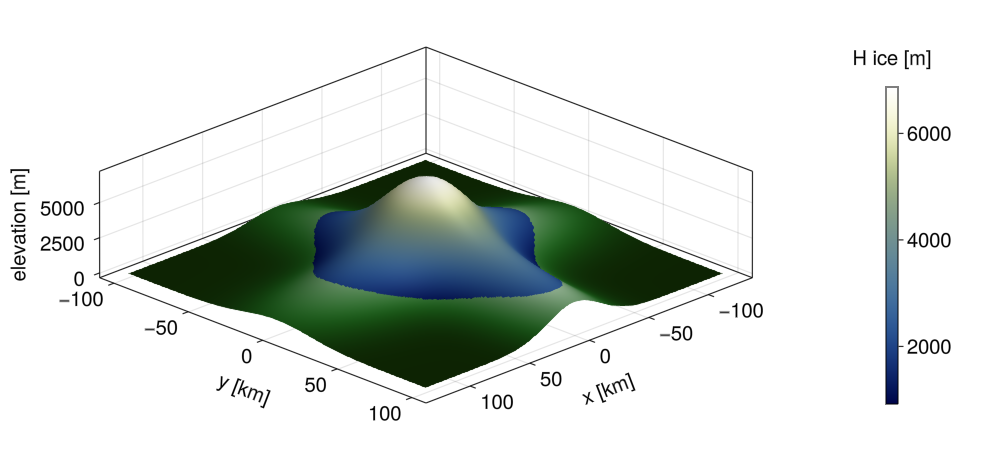

GLMakie.Screen(...)

In [7]:
visualise(S, H)